In [ ]:
#Thanks for clearing my misconception about balanced data
# I executed assignment after changes suggested
# Here I took 60k sample from database . After removing duplicates and so 54458 samples are remained
# Presented confusion matrix using seaborn heatmap
# Please guide me range of K for  cross validation? How many values of K to be used for cross validation as it takes to much time
# In my case This took around 18 hours to run assignment

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#print(os.getcwd())

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 60000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (60000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(54458, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

90.76333333333334

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(54456, 10)


1    45572
0     8884
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)


sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
#sent_1000 = re.sub(r"http\S+", "", sent_1000)
#sent_150 = re.sub(r"http\S+", "", sent_1500)
#sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score


In [19]:
Y =final['Score'].values
X=final['Text'].values
print(X.shape)
print(Y.shape)

(54456,)
(54456,)


In [20]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
X = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    X.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 54456/54456 [00:37<00:00, 1457.48it/s]


In [22]:
print(type(X))

<class 'list'>


In [23]:
X[25000]

'discovered cafe excellent mexican mochas three years ago expensive not visit often discovered powder used make mochas natural tastes great really rich nice spicy undertones cheapest way purchase bulk make mochas home espresso machine steamed milk also loved children hot chocolate'

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(len(X_train), y_train.shape)
print(len(X_cv), y_cv.shape)
print(len(X_test), y_test.shape)

print("="*100)


24444 (24444,)
12041 (12041,)
17971 (17971,)


In [54]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_cv))
print(collections.Counter(y_test))

Counter({1: 20500, 0: 3944})
Counter({1: 10070, 0: 1971})
Counter({1: 15002, 0: 2969})


#Split is applied on preprocessed 54456k samples i.e. X
#Here X_train X_cv and X_test are list. 
#Train size 24444 CRoss Val 12041 and test 17971

# [4] Featurization

## [4.1] BAG OF WORDS

In [22]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand', 'aaah', 'aaf', 'aafco']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (24444, 29342)
the number of unique words  29342


In [23]:
# we use the fitted CountVectorizer to convert the text to vector
#.transform to apply on train, cv and test which will give set 1 of vectorized data
set1_train = count_vect.transform(X_train)
set1_cv = count_vect.transform(X_cv)
set1_test = count_vect.transform(X_test)

print("After vectorizations")
print(set1_train.shape, y_train.shape)
print(set1_cv.shape, y_cv.shape)
print(set1_test.shape, y_test.shape)
print("="*100)

After vectorizations
(24444, 29342) (24444,)
(12041, 29342) (12041,)
(17971, 29342) (17971,)


In [ ]:
# using BoW 29342 Dim vectors are created These to be used as set 1 for KNN using brute

In [24]:
set5_count_vect = CountVectorizer(min_df=10, max_features=500) 
set5_count_vect.fit(X_train)
print("some feature names ", set5_count_vect.get_feature_names()[:10])
print('='*50)

set5_train = set5_count_vect.transform(X_train)
set5_cv = set5_count_vect.transform(X_cv)
set5_test = set5_count_vect.transform(X_test)

print("the type of count vectorizer ",type(set5_train))
print("the shape of out text BOW vectorizer ",set5_train.get_shape())
print(set5_cv.shape, y_cv.shape)
print(set5_test.shape, y_test.shape)
print("="*100)
print("the number of unique words ", set5_train.get_shape()[1])

some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (24444, 500)
(12041, 500) (12041,)
(17971, 500) (17971,)
the number of unique words  500


#Using BoW set 5 of dim 500 is created which is to be used for KNN using KDTree . # as set 5 is in sparse for need to convert it in dense before applying KNN KDTree

## [4.2] Bi-Grams and n-Grams.

In [25]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (24444, 14677)
the number of unique words including both unigrams and bigrams  14677


## [4.3] TF-IDF

#
#.fit applied on X_train only and .transform applied on X_train, X_Cv,X_tset to produce set 2 dataset 
#
#set2_train to use to fit model set2_train set2_cv and set2_test to use for .transform

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

set2_train= tf_idf_vect.transform(X_train)
set2_cv = tf_idf_vect.transform(X_cv)
set2_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(set2_train))
print("the shape of out text TFIDF vectorizer ",set2_train.get_shape())
print(set2_cv.shape, y_cv.shape)
print(set2_test.shape, y_test.shape)
print("the number of unique words including both unigrams and bigrams ", set2_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24444, 14677)
(12041, 14677) (12041,)
(17971, 14677) (17971,)
the number of unique words including both unigrams and bigrams  14677


In [27]:
tf_idf_vect_kdtree = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect_kdtree.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

set6_train = tf_idf_vect_kdtree.transform(X_train)
set6_cv = tf_idf_vect_kdtree.transform(X_cv)
set6_test = tf_idf_vect_kdtree.transform(X_test)
print("the type of count vectorizer ",type(set6_train))
print("the shape of out text TFIDF vectorizer ",set6_train.get_shape())
print(set6_cv.shape, y_cv.shape)
print(set6_test.shape, y_test.shape)
print("the number of unique words including both unigrams and bigrams ", set6_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24444, 500)
(12041, 500) (12041,)
(17971, 500) (17971,)
the number of unique words including both unigrams and bigrams  500


#as .transform applied on X_train in this cell next we will apply .transform on X_cv and X_test only

## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [29]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

# this line of code trains your w2v model on the give list of sentances
w2v_words = list(w2v_model.wv.vocab)

print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

C:\Users\Rajendra\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


[('awesome', 0.8790917992591858), ('amazing', 0.8325502872467041), ('fantastic', 0.7895889282226562), ('excellent', 0.785558819770813), ('good', 0.7527732253074646), ('wonderful', 0.73508220911026), ('perfect', 0.7141999006271362), ('delicious', 0.6838072538375854), ('decent', 0.682537317276001), ('terrific', 0.6770455241203308)]
[('nastiest', 0.8151519298553467), ('closest', 0.7847515344619751), ('best', 0.7508504986763), ('ive', 0.734268069267273), ('eaten', 0.7186506986618042), ('hottest', 0.7135950326919556), ('experienced', 0.6945925951004028), ('freshest', 0.69370037317276), ('addicted', 0.6874316930770874), ('gross', 0.6864479780197144)]
number of words that occured minimum 5 times  9489
sample words  ['love', 'products', 'far', 'flax', 'cereal', 'best', 'tast', 'filling', 'sauce', 'makes', 'easy', 'make', 'fish', 'chicken', 'taste', 'much', 'interesting', 'unique', 'blend', 'sweet', 'spicy', 'not', 'usually', 'saute', 'little', 'olive', 'oil', 'finished', 'add', 'top', 'turn', 

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [30]:
from tqdm import tqdm
import numpy as np

In [31]:
# average Word2Vec
# compute average word2vec for each review.
set3_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    set3_train.append(sent_vec)
set3_train = np.array(set3_train)
print(set3_train.shape)
print(set3_train[0])


100%|███████████████████████████████████████████████████████████████████████████| 24444/24444 [00:30<00:00, 811.69it/s]


(24444, 50)
[ 1.40061764  0.25584026  0.0383425  -0.48738744  0.59006943 -0.10700018
  0.24858132  0.35841975 -0.06173361  0.83606024 -0.37131026 -0.24508039
  0.22774701  0.10603906 -0.62930851  0.20026954  0.24161353  0.17550383
  0.01392117  0.44099093 -0.69681453  0.74418774  0.31308616  0.21159959
 -0.52049118  0.54984205  0.01157809  0.19317308 -0.84076459 -0.07090257
  0.06139229  0.7731638  -0.22979822  0.25865258  0.42323248 -0.7021703
 -1.09378012 -0.27402765  0.46918005  0.17082848  0.48085709  0.75876475
 -0.68885656  0.02898427 -0.06158114  0.46503462  0.08615948  0.16261732
 -0.86031329  0.49494321]


In [32]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [33]:
# average Word2Vec
# compute average word2vec for each review.
set3_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    set3_cv.append(sent_vec)
set3_cv = np.array(set3_cv)
print(set3_cv.shape)
print(set3_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 12041/12041 [00:15<00:00, 790.74it/s]


(12041, 50)
[ 0.7950967   0.85463223 -0.37763011  0.46514822  0.65507656 -0.00126327
 -0.40676158 -0.11481644 -0.01022863  0.14441609  0.0027431   0.11324715
  0.01370269  1.15760614 -0.08573321 -0.03230071  0.32760962 -0.22161534
 -0.27773635  0.02726767 -0.39630287 -0.13032255  0.10166218  0.60156258
  0.32064348  0.40110019 -0.52775059  0.73017437  0.49451147  0.25257223
 -0.16642224  0.7070048  -0.05659197  0.21314481  0.19295499  0.33291991
 -0.03717372 -0.30417964  0.38745837 -0.36540977 -0.16637962  0.38034938
 -0.25762951  0.33879272  0.10187048  0.35714669 -0.0446141   0.34235535
 -0.21870887  0.4218067 ]


In [34]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [35]:
# average Word2Vec
# compute average word2vec for each review.
set3_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    set3_test.append(sent_vec)
set3_test = np.array(set3_test)
print(set3_test.shape)
print(set3_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17971/17971 [00:22<00:00, 802.89it/s]


(17971, 50)
[ 1.42588587e+00  2.24397472e-01 -1.60100677e-01 -1.95281464e-01
  5.80459577e-01  2.99436213e-01 -5.18693759e-02  4.39729126e-02
 -3.44832490e-01  9.96759279e-02 -1.34121807e-01 -2.39955961e-01
  1.18848169e-01  1.08038781e+00 -6.48334112e-01 -4.72329579e-01
 -1.04732405e+00 -9.67641586e-01 -4.07483949e-01  4.89107054e-01
 -1.14529215e+00  4.67143537e-02  1.46706997e-01 -6.33134610e-04
  3.54378904e-01  4.24960361e-01  2.20503666e-01 -4.66505048e-01
  5.31334006e-02  8.12690222e-01 -3.30069481e-01  2.85644930e-02
 -2.55404294e-01  4.99331396e-02  7.26319083e-01  3.39118247e-01
 -2.18757692e-01 -1.55273616e-01  8.06033020e-01  1.63882919e-01
 -1.53052034e-01  4.00603454e-01 -6.28746038e-01  4.71780005e-01
  1.92288615e-01  6.52394462e-01 -8.53080840e-01  8.10698081e-01
 -3.21439827e-01  1.65392111e-02]


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [37]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

set4_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    set4_train.append(sent_vec)
    row += 1
print(len(set4_train))
print(len(set4_train[0]))

100%|████████████████████████████████████████████████████████████████████████████| 24444/24444 [04:25<00:00, 92.19it/s]


24444
50


In [38]:
set4_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    set4_cv.append(sent_vec)
    row += 1
print(len(set4_cv))
print(len(set4_cv[0]))

100%|████████████████████████████████████████████████████████████████████████████| 12041/12041 [02:14<00:00, 89.38it/s]


12041
50


In [39]:
set4_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    set4_test.append(sent_vec)
    row += 1
print(len(set4_test))
print(len(set4_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 17971/17971 [03:20<00:00, 89.81it/s]


17971
50


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191]
K:: 1
cv_rocauc:: 0.5776940664460899
diff_train_cv_roc_auc 0.42141850961881877
K:: 11
cv_rocauc:: 0.6591509358387785
diff_train_cv_roc_auc 0.1592532718493429
K:: 21
cv_rocauc:: 0.6631851519324141
diff_train_cv_roc_auc 0.11742625533023854
K:: 31
cv_rocauc:: 0.6646247449991107
diff_train_cv_roc_auc 0.1049440782829355
K:: 41
cv_rocauc:: 0.6650038517793002
diff_train_cv_roc_auc 0.0986522297029141
K:: 51
cv_rocauc:: 0.6667816658328284
diff_train_cv_roc_auc 0.09709894936531138
K:: 61
cv_rocauc:: 0.671781068794441
diff_train_cv_roc_auc 0.09506488430504934
K:: 71
cv_rocauc:: 0.6776322465219365
diff_train_cv_roc_auc 0.10592812304220534
K:: 81
cv_rocauc:: 0.6946991052485468
diff_train_cv_roc_auc 0.08802652924410637
K:: 91
cv_rocauc:: 0.7120309784829381
diff_train_cv_roc_auc 0.06411105263564887
K:: 101
cv_rocauc:: 0.7278558965979897
diff_train_cv_roc_auc 0.057551366054758524
K:: 111
cv_rocauc:: 0.74240033111

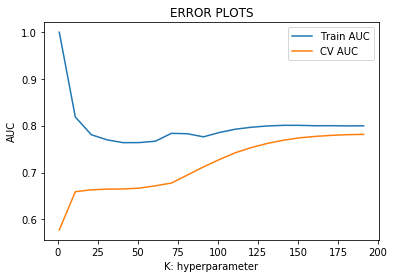

In [42]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
# creating odd list of K for KNN
K = list(range(1,200,10))
print(K)


train_auc = []
cv_auc = []

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'brute')
    neigh.fit(set1_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(set1_train)[:,1]
    y_cv_pred =  neigh.predict_proba(set1_cv)[:,1]
    
    temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
    temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
    diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
    print('K::', i)
    print('cv_rocauc::',temp_cv_rocauc)
    print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
    train_auc.append(temp_train_rocauc)
    cv_auc.append(temp_cv_rocauc)
print(cv_auc)   
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [43]:
best_k_bow_brute = 191

auc for Test data is:: 0.7721289457352694


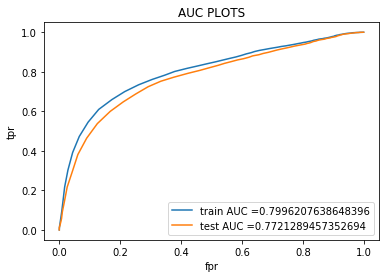

Train confusion matrix
[[   88  3856]
 [   30 20470]]


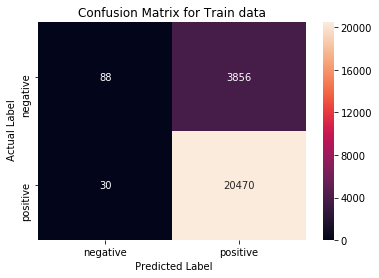

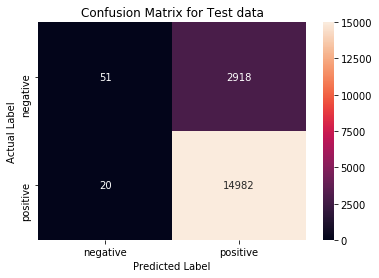

Test confusion matrix
[[   51  2918]
 [   20 14982]]


In [86]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

neigh = KNeighborsClassifier(n_neighbors=best_k_bow_brute)
neigh.fit(set1_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(set1_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(set1_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_bow_brute=auc(test_fpr, test_tpr)
print('auc for Test data is::',auc_bow_brute)

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("AUC PLOTS")
plt.show()

print("="*100)

#y^_train=neigh.predict(set2_train)
#y^_test=neigh.predict(set2_test)
yhat_train=neigh.predict(set1_train)
yhat_test=neigh.predict(set1_test)

con_mat_train = confusion_matrix(y_train, yhat_train)
con_mat_test = confusion_matrix(y_test, yhat_test)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel(" Predicted Label")
plt.ylabel(" Actual Label")
print("Train confusion matrix")
print(con_mat_train)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()
print("Test confusion matrix")
print(con_mat_test)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191]
K:: 1
cv_rocauc:: 0.5070966703395864
diff_train_cv_roc_auc 0.4920159057253223
K:: 11
cv_rocauc:: 0.4999117541995478
diff_train_cv_roc_auc 0.27910475745136987
K:: 21
cv_rocauc:: 0.5075703963679914
diff_train_cv_roc_auc 0.21755958804797848
K:: 31
cv_rocauc:: 0.5088646345192984
diff_train_cv_roc_auc 0.20384759276017528
K:: 41
cv_rocauc:: 0.5056068202440854
diff_train_cv_roc_auc 0.20555922388592995
K:: 51
cv_rocauc:: 0.5050972719124425
diff_train_cv_roc_auc 0.2212186633767278
K:: 61
cv_rocauc:: 0.5001242696356353
diff_train_cv_roc_auc 0.2625670367018702
K:: 71
cv_rocauc:: 0.5054464260072945
diff_train_cv_roc_auc 0.3877038547526124
K:: 81
cv_rocauc:: 0.7930184295925479
diff_train_cv_roc_auc 0.11229004144094545
K:: 91
cv_rocauc:: 0.8275074982479317
diff_train_cv_roc_auc 0.06467600370625626
K:: 101
cv_rocauc:: 0.8443081584665838
diff_train_cv_roc_auc 0.04729556191139073
K:: 111
cv_rocauc:: 0.856189927735

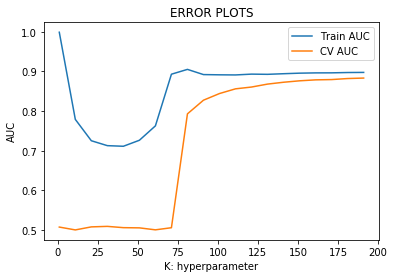

In [45]:
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
# creating odd list of K for KNN
K = list(range(1,200,10))
print(K)


train_auc = []
cv_auc = []

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'brute')
    neigh.fit(set2_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(set2_train)[:,1]
    y_cv_pred =  neigh.predict_proba(set2_cv)[:,1]
    
    temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
    temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
    diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
    print('K::', i)
    print('cv_rocauc::',temp_cv_rocauc)
    print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
    train_auc.append(temp_train_rocauc)
    cv_auc.append(temp_cv_rocauc)
print(cv_auc)   
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [46]:
best_k_tfidf_brute = 191

auc for Test data is:: 0.8793897986611777


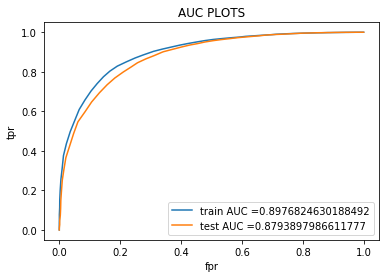

Train confusion matrix
[[    7  3937]
 [    0 20500]]


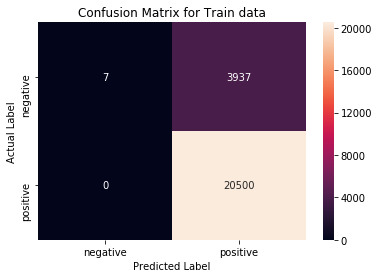

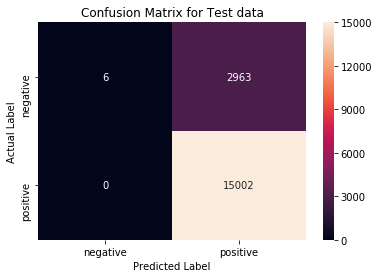

Test confusion matrix
[[    6  2963]
 [    0 15002]]


In [83]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_tfidf_brute)
neigh.fit(set2_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(set2_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(set2_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_tfidf_brute=auc(test_fpr, test_tpr)
print('auc for Test data is::',auc_tfidf_brute)

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("AUC PLOTS")
plt.show()

print("="*100)

yhat_train=neigh.predict(set2_train)
yhat_test=neigh.predict(set2_test)

con_mat_train = confusion_matrix(y_train, yhat_train)
con_mat_test = confusion_matrix(y_test, yhat_test)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
print("Train confusion matrix")
print(con_mat_train)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()
print("Test confusion matrix")
print(con_mat_test)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191]
K:: 1
cv_rocauc:: 0.6592945525411416
diff_train_cv_roc_auc 0.3398180235237671
K:: 11
cv_rocauc:: 0.8284262068110745
diff_train_cv_roc_auc 0.08054708389292786
K:: 21
cv_rocauc:: 0.8496343454771446
diff_train_cv_roc_auc 0.04913219091032883
K:: 31
cv_rocauc:: 0.8589832864519645
diff_train_cv_roc_auc 0.03418398213755702
K:: 41
cv_rocauc:: 0.8611720493330048
diff_train_cv_roc_auc 0.02845453999069769
K:: 51
cv_rocauc:: 0.8630925983866361
diff_train_cv_roc_auc 0.024571652343092443
K:: 61
cv_rocauc:: 0.8641395820328225
diff_train_cv_roc_auc 0.021742925511826994
K:: 71
cv_rocauc:: 0.8641183707956027
diff_train_cv_roc_auc 0.02013683624936835
K:: 81
cv_rocauc:: 0.8647282820358958
diff_train_cv_roc_auc 0.018421572018425536
K:: 91
cv_rocauc:: 0.8634437174179526
diff_train_cv_roc_auc 0.018306369159992397
K:: 101
cv_rocauc:: 0.863217951256476
diff_train_cv_roc_auc 0.0174527062411739
K:: 111
cv_rocauc:: 0.8641334

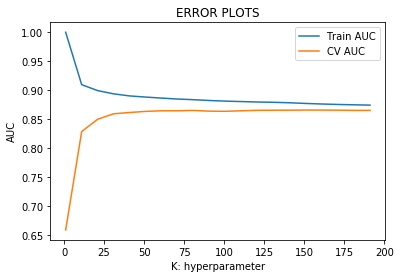

In [57]:
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
# creating odd list of K for KNN
K = list(range(1,200,10))
print(K)


train_auc = []
cv_auc = []

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'brute')
    neigh.fit(set3_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(set3_train)[:,1]
    y_cv_pred =  neigh.predict_proba(set3_cv)[:,1]
    
    temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
    temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
    diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
    print('K::', i)
    print('cv_rocauc::',temp_cv_rocauc)
    print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
    train_auc.append(temp_train_rocauc)
    cv_auc.append(temp_cv_rocauc)
print(cv_auc)   
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [58]:
best_k_avgW2V_brute = 151

auc for Test data is:: 0.86548688085554


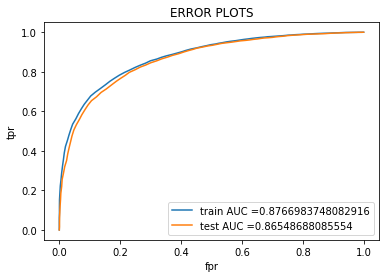

Train confusion matrix
[[  679  3265]
 [  168 20332]]


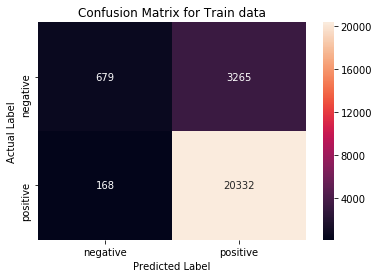

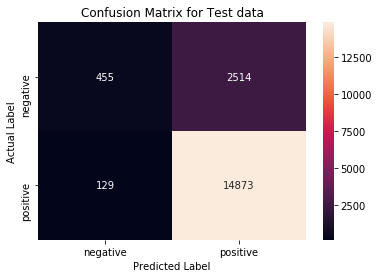

Test confusion matrix
[[  455  2514]
 [  129 14873]]


In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_avgW2V_brute)
neigh.fit(set3_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(set3_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(set3_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_avgW2V_brute=auc(test_fpr, test_tpr)
print('auc for Test data is::',auc_avgW2V_brute)

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

yhat_train=neigh.predict(set3_train)
yhat_test=neigh.predict(set3_test)

con_mat_train = confusion_matrix(y_train, yhat_train)
con_mat_test = confusion_matrix(y_test, yhat_test)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
print("Train confusion matrix")
print(con_mat_train)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()
print("Test confusion matrix")
print(con_mat_test)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191]
K:: 1
cv_rocauc:: 0.6210757825611384
diff_train_cv_roc_auc 0.3780367935037703
K:: 11
cv_rocauc:: 0.7956089715975991
diff_train_cv_roc_auc 0.09710281042387214
K:: 21
cv_rocauc:: 0.8155889493988554
diff_train_cv_roc_auc 0.06133431780541909
K:: 31
cv_rocauc:: 0.822761194217847
diff_train_cv_roc_auc 0.045051308874222484
K:: 41
cv_rocauc:: 0.8251622961945226
diff_train_cv_roc_auc 0.03900254202840325
K:: 51
cv_rocauc:: 0.8288378861918875
diff_train_cv_roc_auc 0.0337754505221084
K:: 61
cv_rocauc:: 0.8301056228924167
diff_train_cv_roc_auc 0.03027669294392621
K:: 71
cv_rocauc:: 0.8318270835758015
diff_train_cv_roc_auc 0.026199446380167468
K:: 81
cv_rocauc:: 0.8326412726339267
diff_train_cv_roc_auc 0.0232844002003878
K:: 91
cv_rocauc:: 0.8334463423715374
diff_train_cv_roc_auc 0.02117046982853188
K:: 101
cv_rocauc:: 0.8329333679968278
diff_train_cv_roc_auc 0.02015232561619351
K:: 111
cv_rocauc:: 0.8328514956

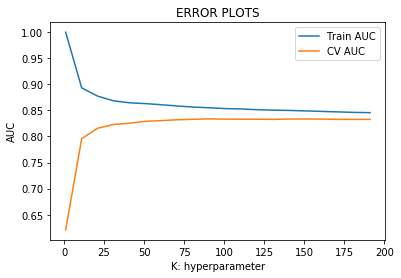

In [61]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
# creating odd list of K for KNN
K = list(range(1,200,10))
print(K)


train_auc = []
cv_auc = []

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'brute')
    neigh.fit(set4_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(set4_train)[:,1]
    y_cv_pred =  neigh.predict_proba(set4_cv)[:,1]
    
    temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
    temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
    diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
    print('K::', i)
    print('cv_rocauc::',temp_cv_rocauc)
    print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
    train_auc.append(temp_train_rocauc)
    cv_auc.append(temp_cv_rocauc)
print(cv_auc)   
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [62]:
best_k_tfidfW2V_brute = 151

auc for Test data is:: 0.8345997787473627


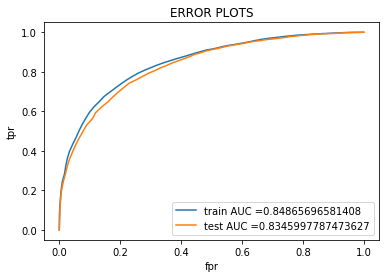

Train confusion matrix
[[  446  3498]
 [  112 20388]]


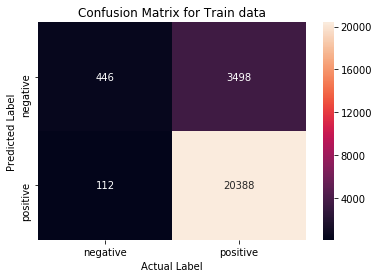

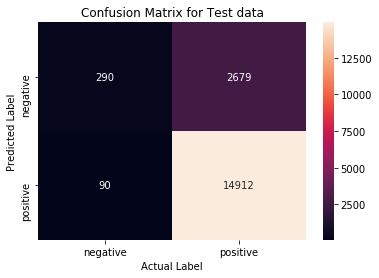

Test confusion matrix
[[  290  2679]
 [   90 14912]]


In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_tfidfW2V_brute)
neigh.fit(set4_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(set4_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(set4_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_iftdfW2V_brute=auc(test_fpr, test_tpr)
print('auc for Test data is::',auc_iftdfW2V_brute)

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

yhat_train=neigh.predict(set4_train)
yhat_test=neigh.predict(set4_test)

con_mat_train = confusion_matrix(y_train, yhat_train)
con_mat_test = confusion_matrix(y_test, yhat_test)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
print("Train confusion matrix")
print(con_mat_train)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.show()
print("Test confusion matrix")
print(con_mat_test)


## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

As KDTree works on dense and set 5 in sparse form need to covert it in dense using .toarray()

In [64]:
set5_train=set5_train.toarray()
set5_cv=set5_cv.toarray()
set5_test=set5_test.toarray()
print(type(set5_train))
print(type(set5_cv))
print(type(set5_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]
K:: 1
cv_rocauc:: 0.6167180573126622
diff_train_cv_roc_auc 0.382014194208636
K:: 11
cv_rocauc:: 0.7270627928196184
diff_train_cv_roc_auc 0.11390847567095697
K:: 21
cv_rocauc:: 0.7550458812664469
diff_train_cv_roc_auc 0.07218080452982278
K:: 31
cv_rocauc:: 0.7546746846151017
diff_train_cv_roc_auc 0.059084665802946246
K:: 41
cv_rocauc:: 0.7497816905204915
diff_train_cv_roc_auc 0.0538467416766093
K:: 51
cv_rocauc:: 0.7513916788467536
diff_train_cv_roc_auc 0.04478894129869737
K:: 61
cv_rocauc:: 0.7525949757078432
diff_train_cv_roc_auc 0.038442382675375586
K:: 71
cv_rocauc:: 0.7582128550174149
diff_train_cv_roc_auc 0.03447101798510832
K:: 81
cv_rocauc:: 0.7602548774509433
diff_train_cv_roc_auc 0.03146843798961474
K:: 91
cv_rocauc:: 0.7703409467063885
diff_train_cv_roc_auc 0.0216787312236566
[0.6167180573126622, 0.7270627928196184, 0.7550458812664469, 0.7546746846151017, 0.7497816905204915, 0.7513916788467536, 0.7525949757078432, 0.7582128550174149, 0.

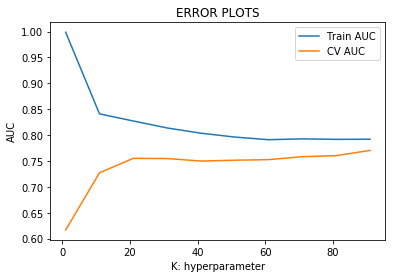

In [65]:
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
# creating odd list of K for KNN
K = list(range(1,100,10))
print(K)

train_auc = []
cv_auc = []

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'kd_tree')
    neigh.fit(set5_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(set5_train)[:,1]
    y_cv_pred =  neigh.predict_proba(set5_cv)[:,1]
    
    temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
    temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
    diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
    print('K::', i)
    print('cv_rocauc::',temp_cv_rocauc)
    print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
    train_auc.append(temp_train_rocauc)
    cv_auc.append(temp_cv_rocauc)
print(cv_auc)   
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [66]:
best_k_bow_kdtree = 91

auc for Test data is:: 0.7586212486140278


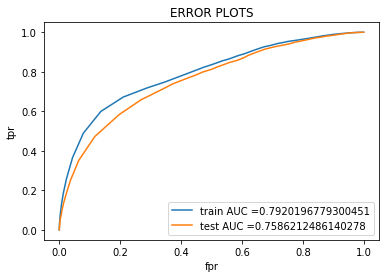

Train confusion matrix
[[  500  3444]
 [  342 20158]]


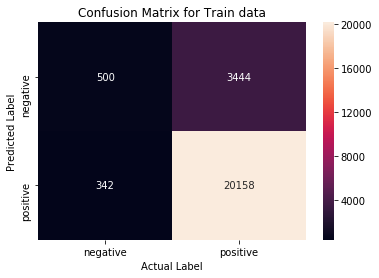

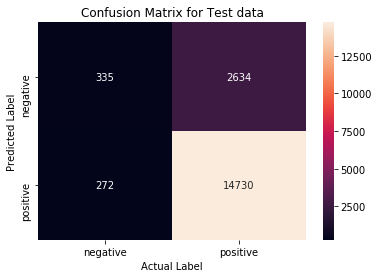

Test confusion matrix
[[  335  2634]
 [  272 14730]]


In [68]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_bow_kdtree)
neigh.fit(set5_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(set5_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(set5_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_bow_kdtree=auc(test_fpr, test_tpr)
print('auc for Test data is::',auc_bow_kdtree)

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

yhat_train=neigh.predict(set5_train)
yhat_test=neigh.predict(set5_test)

con_mat_train = confusion_matrix(y_train, yhat_train)
con_mat_test = confusion_matrix(y_test, yhat_test)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
print("Train confusion matrix")
print(con_mat_train)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.show()
print("Test confusion matrix")
print(con_mat_test)


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [69]:
set6_train=set6_train.toarray()
set6_cv=set6_cv.toarray()
set6_test=set6_test.toarray()
print(type(set6_train))
print(type(set6_cv))
print(type(set6_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]
K:: 1
cv_rocauc:: 0.5676426354937054
diff_train_cv_roc_auc 0.43108961602759277
K:: 11
cv_rocauc:: 0.5950578824937766
diff_train_cv_roc_auc 0.20421162846451757
K:: 21
cv_rocauc:: 0.5615044762764152
diff_train_cv_roc_auc 0.1969212893199831
K:: 31
cv_rocauc:: 0.5982544814406713
diff_train_cv_roc_auc 0.22195455482311943
K:: 41
cv_rocauc:: 0.6089808176856374
diff_train_cv_roc_auc 0.23188724371049374
K:: 51
cv_rocauc:: 0.6126054452923901
diff_train_cv_roc_auc 0.205922228729279
K:: 61
cv_rocauc:: 0.6035415208709002
diff_train_cv_roc_auc 0.1730250575687179
K:: 71
cv_rocauc:: 0.6140970336009174
diff_train_cv_roc_auc 0.2324923766795951
K:: 81
cv_rocauc:: 0.6111756517165232
diff_train_cv_roc_auc 0.2358311632045671
K:: 91
cv_rocauc:: 0.7607520567594569
diff_train_cv_roc_auc 0.09810803328160589
[0.5676426354937054, 0.5950578824937766, 0.5615044762764152, 0.5982544814406713, 0.6089808176856374, 0.6126054452923901, 0.6035415208709002, 0.6140970336009174, 0.6111

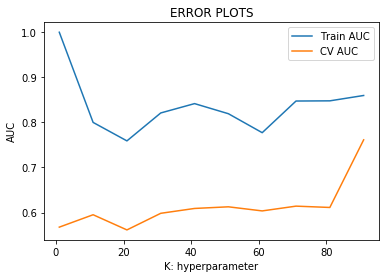

In [70]:
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
# creating odd list of K for KNN
K = list(range(1,100,10))
print(K)

train_auc = []
cv_auc = []

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'kd_tree')
    neigh.fit(set6_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(set6_train)[:,1]
    y_cv_pred =  neigh.predict_proba(set6_cv)[:,1]
    
    temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
    temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
    diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
    print('K::', i)
    print('cv_rocauc::',temp_cv_rocauc)
    print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
    train_auc.append(temp_train_rocauc)
    cv_auc.append(temp_cv_rocauc)
print(cv_auc)   
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [78]:
best_k_tfidf_kdtree= 91

auc for Test data is:: 0.7580545227853082


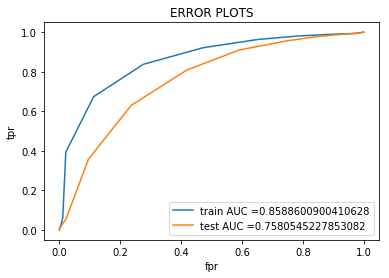

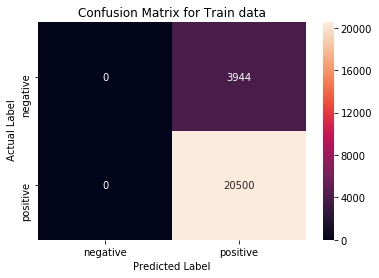

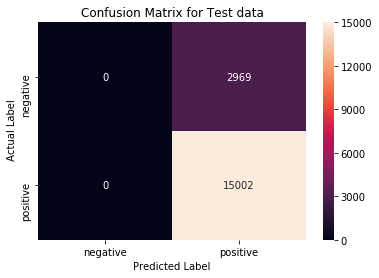

In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_tfidf_kdtree)
neigh.fit(set6_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(set6_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(set6_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_tfidf_kdtree=auc(test_fpr, test_tpr)
print('auc for Test data is::',auc_tfidf_kdtree)

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

yhat_train=neigh.predict(set6_train)
yhat_test=neigh.predict(set6_test)

con_mat_train = confusion_matrix(y_train, yhat_train)
con_mat_test = confusion_matrix(y_test, yhat_test)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel(" Actual Label") 
#print("Train confusion matrix")
#print(con_mat_train)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel(" Actual Label") 
plt.show()
#print("Test confusion matrix")
#print(con_mat_test)


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]
K:: 1
cv_rocauc:: 0.6592945525411416
diff_train_cv_roc_auc 0.3398180235237671
K:: 11
cv_rocauc:: 0.8284262068110745
diff_train_cv_roc_auc 0.08054708389292786
K:: 21
cv_rocauc:: 0.8493822290138489
diff_train_cv_roc_auc 0.04874286993237387
K:: 31
cv_rocauc:: 0.8588264694071988
diff_train_cv_roc_auc 0.03390076677743481
K:: 41
cv_rocauc:: 0.8610636251465515
diff_train_cv_roc_auc 0.028222787063412302
K:: 51
cv_rocauc:: 0.8630034960754173
diff_train_cv_roc_auc 0.024389617267481012
K:: 61
cv_rocauc:: 0.8641525052688008
diff_train_cv_roc_auc 0.021730002275848648
K:: 71
cv_rocauc:: 0.8641234090942298
diff_train_cv_roc_auc 0.02013179795074127
K:: 81
cv_rocauc:: 0.8647367715690824
diff_train_cv_roc_auc 0.018413082485238985
K:: 91
cv_rocauc:: 0.8634437174179526
diff_train_cv_roc_auc 0.018306369159992397
[0.6592945525411416, 0.8284262068110745, 0.8493822290138489, 0.8588264694071988, 0.8610636251465515, 0.8630034960754173, 0.8641525052688008, 0.86412340909422

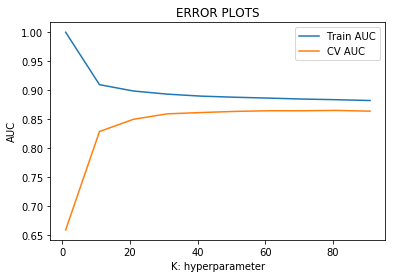

In [72]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
# creating odd list of K for KNN
K = list(range(1,100,10))
print(K)

train_auc = []
cv_auc = []

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'kd_tree')
    neigh.fit(set3_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(set3_train)[:,1]
    y_cv_pred =  neigh.predict_proba(set3_cv)[:,1]
    
    temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
    temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
    diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
    print('K::', i)
    print('cv_rocauc::',temp_cv_rocauc)
    print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
    train_auc.append(temp_train_rocauc)
    cv_auc.append(temp_cv_rocauc)
print(cv_auc)   
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [73]:
best_k_avgW2V_kdtree = 81

auc for Test data is:: 0.864423847562438


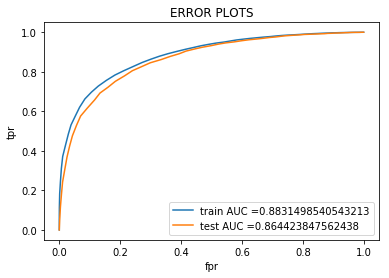

Train confusion matrix
[[  847  3097]
 [  238 20262]]


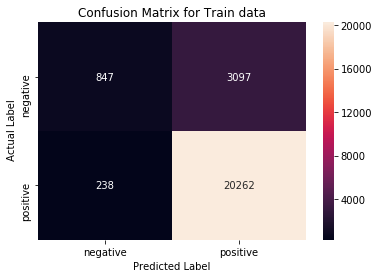

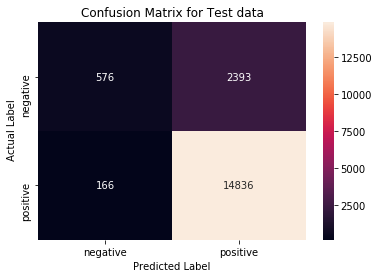

Test confusion matrix
[[  576  2393]
 [  166 14836]]


In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_avgW2V_kdtree)
neigh.fit(set3_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(set3_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(set3_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_avgW2V_kdtree=auc(test_fpr, test_tpr)
print('auc for Test data is::',auc_avgW2V_kdtree)

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

yhat_train=neigh.predict(set3_train)
yhat_test=neigh.predict(set3_test)

con_mat_train = confusion_matrix(y_train, yhat_train)
con_mat_test = confusion_matrix(y_test, yhat_test)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel(" Actual Label") 
print("Train confusion matrix")
print(con_mat_train)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel(" Actual Label") 
plt.show()
print("Test confusion matrix")
print(con_mat_test)


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]
K:: 1
cv_rocauc:: 0.6210757825611384
diff_train_cv_roc_auc 0.3780367935037703
K:: 11
cv_rocauc:: 0.7955451111625016
diff_train_cv_roc_auc 0.09669148780845771
K:: 21
cv_rocauc:: 0.8155573340749709
diff_train_cv_roc_auc 0.06113173360424551
K:: 31
cv_rocauc:: 0.8227650737077898
diff_train_cv_roc_auc 0.04505015658954359
K:: 41
cv_rocauc:: 0.8251341572966907
diff_train_cv_roc_auc 0.03892053522792227
K:: 51
cv_rocauc:: 0.8287755876293645
diff_train_cv_roc_auc 0.03355227067964439
K:: 61
cv_rocauc:: 0.83008234595276
diff_train_cv_roc_auc 0.03021699110754772
K:: 71
cv_rocauc:: 0.8318270835758015
diff_train_cv_roc_auc 0.02620083781142457
K:: 81
cv_rocauc:: 0.8326412726339267
diff_train_cv_roc_auc 0.023285482424698856
K:: 91
cv_rocauc:: 0.8334463423715374
diff_train_cv_roc_auc 0.02117046982853188
[0.6210757825611384, 0.7955451111625016, 0.8155573340749709, 0.8227650737077898, 0.8251341572966907, 0.8287755876293645, 0.83008234595276, 0.8318270835758015, 0.83

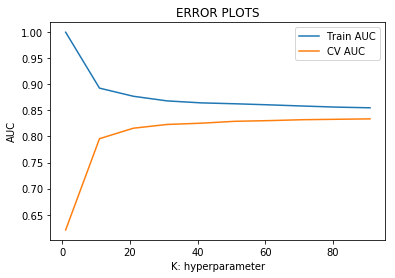

In [75]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""
# creating odd list of K for KNN
K = list(range(1,100,10))
print(K)

train_auc = []
cv_auc = []

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm = 'kd_tree')
    neigh.fit(set4_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(set4_train)[:,1]
    y_cv_pred =  neigh.predict_proba(set4_cv)[:,1]
    
    temp_train_rocauc=roc_auc_score(y_train,y_train_pred)
    temp_cv_rocauc=roc_auc_score(y_cv, y_cv_pred)
    diff_train_cv_roc_auc=temp_train_rocauc-temp_cv_rocauc
    print('K::', i)
    print('cv_rocauc::',temp_cv_rocauc)
    print('diff_train_cv_roc_auc',diff_train_cv_roc_auc)
    train_auc.append(temp_train_rocauc)
    cv_auc.append(temp_cv_rocauc)
print(cv_auc)   
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [76]:
best_k_tfidfW2V_kdtree = 91

auc for Test data is:: 0.8347305011852242


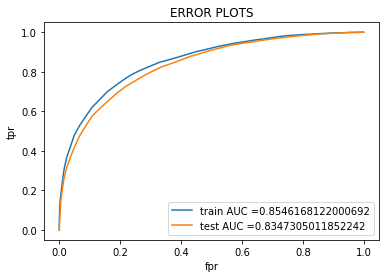

Train confusion matrix
[[  561  3383]
 [  143 20357]]


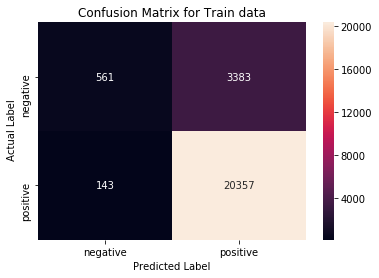

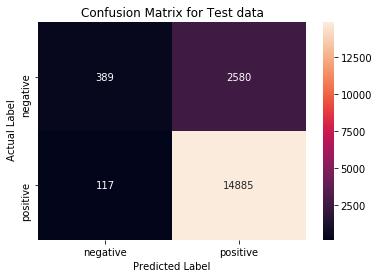

Test confusion matrix
[[  389  2580]
 [  117 14885]]


In [77]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_tfidfW2V_kdtree)
neigh.fit(set4_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(set4_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(set4_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_tfidfW2V_kdtree=auc(test_fpr, test_tpr)
print('auc for Test data is::',auc_tfidfW2V_kdtree)

plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

yhat_train=neigh.predict(set4_train)
yhat_test=neigh.predict(set4_test)

con_mat_train = confusion_matrix(y_train, yhat_train)
con_mat_test = confusion_matrix(y_test, yhat_test)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel(" Actual Label") 
print("Train confusion matrix")
print(con_mat_train)

plt.figure()
class_label = ["negative", "positive"]
df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel(" Actual Label") 
plt.show()
print("Test confusion matrix")
print(con_mat_test)


# [6] Conclusions

In [87]:
# Please compare all your models using Prettytable library
#best_k_bow_kdtree = 41
#auc_tfidfW2V_kdtree
from prettytable import PrettyTable
result=PrettyTable()
result.field_names=["Vectorizer","dataset","Model","Hyperparameter","AUC"]
result.add_row(["BoW","set1","brute",best_k_bow_brute,auc_bow_brute])
result.add_row(["TfIdf","set2","brute",best_k_tfidf_brute,auc_tfidf_brute])
result.add_row(["AvgW2V","set3","brute",best_k_avgW2V_brute,auc_avgW2V_brute])
result.add_row(["TfIdfW2V","set4","brute",best_k_tfidfW2V_brute,auc_iftdfW2V_brute])

result.add_row(["BoW","set5","kdtree",best_k_bow_kdtree,auc_bow_kdtree])
result.add_row(["TfIdf","set6","kdtree",best_k_tfidf_kdtree,auc_tfidf_kdtree])
result.add_row(["AvgW2V","set3","kdtree",best_k_avgW2V_kdtree,auc_avgW2V_kdtree])
result.add_row(["TfIdfW2V","set4","kdtree",best_k_tfidfW2V_kdtree,auc_tfidfW2V_kdtree])


print(result)

+------------+---------+--------+----------------+--------------------+
| Vectorizer | dataset | Model  | Hyperparameter |        AUC         |
+------------+---------+--------+----------------+--------------------+
|    BoW     |   set1  | brute  |      191       | 0.7721289457352694 |
|   TfIdf    |   set2  | brute  |      191       | 0.8793897986611777 |
|   AvgW2V   |   set3  | brute  |      151       |  0.86548688085554  |
|  TfIdfW2V  |   set4  | brute  |      151       | 0.8345997787473627 |
|    BoW     |   set5  | kdtree |       91       | 0.7586212486140278 |
|   TfIdf    |   set6  | kdtree |       91       | 0.7580545227853082 |
|   AvgW2V   |   set3  | kdtree |       81       | 0.864423847562438  |
|  TfIdfW2V  |   set4  | kdtree |       91       | 0.8347305011852242 |
+------------+---------+--------+----------------+--------------------+
